# Discrete Skeleton Evolution

In [1]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2
import fractions
import math
from matplotlib import image
import random
from skimage import morphology,feature
import glob, os

In [2]:
def get_imp_points(img):
    """
    This function gets the end points and intersection points given a binary mask.
    """
    end_points = []
    inter_points = []
    (rows,cols) = np.nonzero(img)
    
    for (r,c) in zip(rows,cols):

        if np.sum(img[r-1:r+2,c-1:c+2]) == 2:
            end_points.append((c,r))
        elif np.sum(img[r-1:r+2,c-1:c+2]) > 3:
            inter_points.append((c,r))
            
    return end_points, inter_points

In [3]:
def get_branches(img):
    """
    This algorithm gets the branches of the skeleton image from end points to
    intersection point. The determined branches are used for DSE pruning method.
    
    Branches from one intersection point to another intersection point is not considered
    because it is definitely important to the reconstruction of the binary image.
    
    i.e. Only end point to intersection point is considered. 
    
    Arguments:
    img - Skeletonized image
    
    Return
    all_branches - A list of lists of coordinates (x,y) of the branches
    """
    
    E,_ = get_imp_points(img)  
    all_branches = []
    
    #print(f"The end points: {E}")
    for e in E:
        branch = []
        r_g, c_g = e[1], e[0]
        branch.append((c_g,r_g))

        while np.sum(img[r_g-1:r_g+2,c_g-1:c_g+2]) <= 3:
            (r_t,c_t) = np.nonzero(img[r_g-1:r_g+2,c_g-1:c_g+2])
            r_t = r_t-1+r_g
            c_t = c_t-1+c_g
            for point in zip(c_t,r_t):
                if point not in branch:
                    branch.append(point)

            r_g = branch[-1][1]
            c_g = branch[-1][0]
            if (c_g,r_g) in E:
                branch = []
                break
        if len(branch) > 0:
            all_branches.append(branch)
    
    return all_branches      

In [4]:
def get_avg_curve_len(img):
    """
    This algorithm gets the averaged curve length
    
    Branches from one intersection point to another intersection point is not considered
    because it is definitely important to the reconstruction of the binary image.
    
    i.e. Only end point to intersection point is considered. 
    
    Arguments:
    img - Skeletonized image
    
    Return
    all_branches - A list of lists of coordinates (x,y) of the branches
    """
       
    all_branch_len = []
    s = img.copy()*1
    i = 0
    
    while True:

        all_branch = get_branches(s)
        for branch in all_branch:
            all_branch_len.append(len(branch))
            r = [i[1] for i in branch]
            c = [i[0] for i in branch]

            s[r,c] = 0
        if i != 0:
            all_branch_len.append(np.sum(s))
                
        if len(all_branch) == 0:
            break
        
        i += 1
    try:
        avg_len = np.mean(all_branch_len)
    except:
        return 0
    return avg_len

In [5]:
def get_num_branch(all_branches,inter_points):
    
    list_num_branch = []
    for point in inter_points:
        num_branch = 0
        for branch in all_branches:
            if point in branch:
                all_branches.remove(branch)
                num_branch += 1
        list_num_branch.append(num_branch)
        
    return list_num_branch

In [6]:
def reconstruct(skel_img,dist_tr):
    """
    Attempt to reconstruct the binary image from the skeleton
    
    Arguments:
    img - Skeleton image using thinning algorithm
    dist_tr - Distance transform matrix
    
    Return:
    bn_img - Binary image
    """
    row, col = np.nonzero(skel_img)
    bn_img = skel_img.copy()*1
    for (r,c) in zip(row,col):
        radius = math.ceil(dist_tr[r,c]-1)
        if radius >= 1:
            stel = morphology.disk(radius)
            bn_img[r-radius:r+radius+1,c-radius:c+radius+1] += stel
    
    return bn_img >= 1

In [7]:
def DSE(img,beta):
    """
    Discrete Skeletonization Evolution algorithm which finds the trade 
    off between skeleton simplicity and reconstruction error.
    
    Arguments:
    img - Binary image
    
    Returns:
    pruned_img - Pruned binary image using DSE
    """    
    
    M,dist = morphology.medial_axis(img,return_distance = True)
    #M = morphology.skeletonize(img)
    S_all = [M]
    norm_dist = lambda s: np.log(np.sum(s)+1)
    norm_area = lambda s,d: (np.sum(d)-np.sum(reconstruct(s,dist)))/(np.sum(d))    
    avg_width = 0
    r,c = np.nonzero(M)
    all_branches = get_branches(M)

    M_len = norm_dist(get_avg_curve_len(M))
    avg_branch_len = np.mean([len(branch) for branch in all_branches]) # Average length of all branches
    scores = [norm_area(M,reconstruct(M,dist))+norm_dist(M)]
    
    while len(all_branches) > 2:
        weights = []
        for branch in all_branches:
            """
            Iteratively removes each branch and then assigns the weight for each branch
            """
            S = M.copy()                  # S_(i) 
            r = [i[1] for i in branch]
            c = [i[0] for i in branch]

            S[r,c] = 0                    # Initialize the weights

            AR = norm_area(S,img)
            LR = norm_dist(S) # get_avg_curve_len(S)
            weights.append(AR + LR)

        min_idx = np.argmin(weights)
        E = all_branches[min_idx]         # The minimum branch to be removed 
        r = [i[1] for i in E]             # Get the rows of minimum weight branch
        c = [i[0] for i in E]             # Get the columns of minimum weight branch
        M[r,c] = 0                        # Remove the minimum branch from the medial axis, S_(i+1)
        S_all.append(M)
        del all_branches[min_idx]    

    for S in S_all:
        AR = norm_area(img,reconstruct(S,dist))
        LR = norm_dist(get_avg_curve_len(S))
        scores.append(AR + LR)
        S_best = S_all[np.argmin(scores)]

        return S_best

# Test cases

Length of S_all: 7
Wall time: 2.15 s


(-0.5, 641.5, 361.5, -0.5)

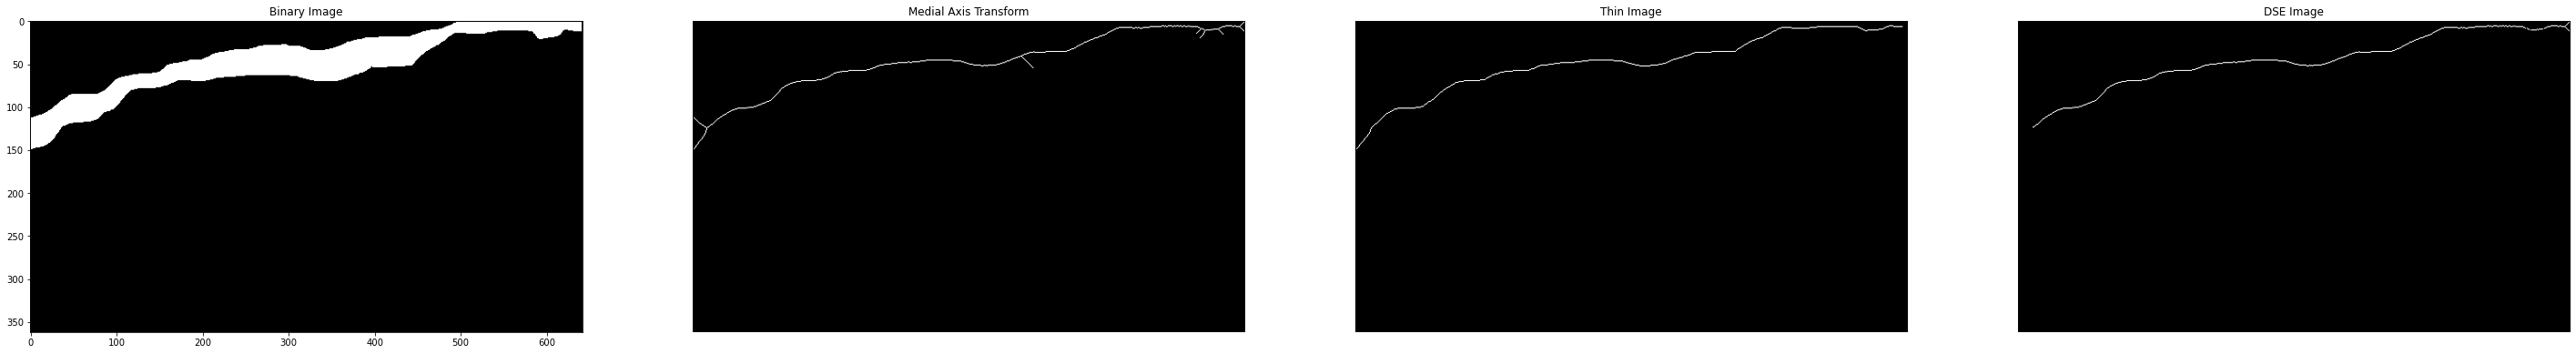

In [10]:
if __name__ == "__main__":
    
    %%time

    folder_path = "../Crack500/validation"
    mask_paths = sorted(glob.glob(os.path.join(folder_path,'mask','*png')))

    mask_files = []
    for path in mask_paths:
        mask = cv2.imread(path,cv2.IMREAD_UNCHANGED)
        mask_files.append(mask)


    # padding 
    padded_mask = []
    for mask in mask_files:
        pad_mask = np.pad(mask,((1,1),(1,1)),"constant")
        padded_mask.append(pad_mask)


    test_img = padded_mask[3]
    skeleton_medial,test = morphology.medial_axis(test_img,return_distance=True)
    skeleton_thin = morphology.thin(test_img)
    beta = 20 

    dse_v3 = DSE(test_img,beta)
    # thin_img_wf,_ = DSE_v3(test_img,beta)
    fig,ax = plt.subplots(nrows = 1, ncols = 4,figsize = (50,50), squeeze = True)
    ax[0].imshow(test_img,cmap="Greys_r")
    ax[0].set_title(f"Binary Image")

    ax[1].imshow(skeleton_medial,cmap="Greys_r")
    ax[1].set_title(f"Medial Axis Transform")
    ax[1].axis("off")

    ax[2].imshow(skeleton_thin,cmap="Greys_r")
    ax[2].set_title(f"Thin Image")
    ax[2].axis("off")

    ax[3].imshow(dse_v3,cmap="Greys_r")
    ax[3].set_title(f"DSE Image")
    ax[3].axis("off")